In [2]:
%pylab inline
from numpy import *
from numpy.random import rand, randn, randint
from dPCA import dPCA

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


We first build surrogate data to apply dPCA to.

In [4]:
#construct trialR
#shape: #trials X neurons X actions X forces
#4 neurons, 2 actions, 3 forces
num_neurons = 2
#Make trial dictionaries and then assemble them into a tensor
force_array = np.array([0, 1, 2]); 
num_force = len(force_array)
action_list = ['A', 'B']
num_actions = len(action_list)

X = np.zeros((num_neurons, num_actions, num_force))

# #------------------------------
# i_n = 0

# i_a = 0
# offset=0
# slope=1
# y = force_array*slope+offset
# X[i_n, i_a, :] = y

# i_a = 1
# offset=0
# slope=1
# y = force_array*slope+offset
# X[i_n, i_a, :] = y

# #------------------------------
# i_n = 1

# i_a = 0
# offset=0
# slope=0
# y = force_array*slope+offset
# X[i_n, i_a, :] = y

# i_a = 1
# offset=1
# slope=0
# y = force_array*slope+offset
# X[i_n, i_a, :] = y

#------------------------------
i_n = 0

i_a = 0
offset=0
slope=1
y = force_array*slope+offset
X[i_n, i_a, :] = y

i_a = 1
offset=0
slope=0
y = force_array*slope+offset
X[i_n, i_a, :] = y

#------------------------------
i_n = 1

i_a = 0
offset=0
slope=0
y = force_array*slope+offset
X[i_n, i_a, :] = y

i_a = 1
offset=0
slope=1
y = force_array*slope+offset
X[i_n, i_a, :] = y

In [5]:
X.shape

(2, 2, 3)

In [6]:
X

array([[[0., 1., 2.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 1., 2.]]])

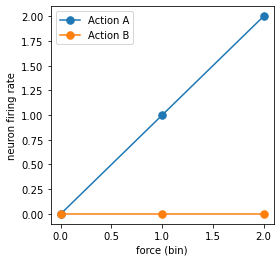

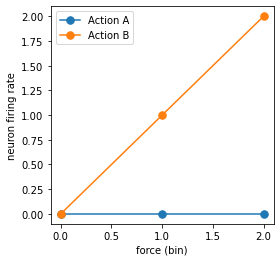

In [28]:
for i_n in range(num_neurons):
    plt.figure(figsize=(4,4))
    for i_a in range(num_actions):
        plt.plot(X[i_n, i_a,:], '.-', markersize=15, label='Action '+action_list[i_a])
    xlabel('force (bin)')
    ylabel('neuron firing rate')
    plt.legend()

In [11]:
num_trials = 10
noise = 0.3

trialR = randn(num_trials, num_neurons, num_actions, num_force)*noise
trialR += X[None,:,:,:]

# trialR[5:,:,1,:] = np.nan #test setting some trials to nan

#trial-average data
R = np.nanmean(trialR, 0)

# center data
R -= np.nanmean(R.reshape((num_neurons,-1)),1)[:,None,None]

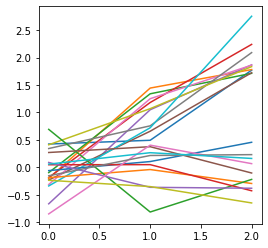

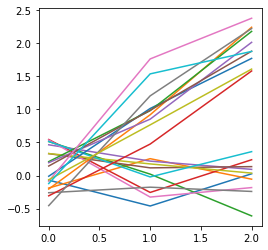

In [12]:
for i_n in range(num_neurons):
    plt.figure(figsize=(4,4))
    for i_a in range(num_actions):
        for i_tr in range(num_trials):
            plt.plot(trialR[i_tr, i_n, i_a,:])

# for i_n in range(num_neurons):
#     plt.figure(figsize=(4,4))
#     for i_a in range(num_actions):
#         plt.plot(R[i_n, i_a,:], '.-', markersize=10, label='action '+action_list[i_a])
#     plt.xlabel('force (bin)')
#     plt.ylabel('activity')
#     plt.title('neuron '+str(i_n))
#     plt.legend()

In [13]:
trialR.shape #trials X neurons X num_actions X num_force

(10, 2, 2, 3)

In [14]:
R.shape #neurons X num_actions X num_force

(2, 2, 3)

In [15]:
del dpca

NameError: name 'dpca' is not defined

In [16]:
dpca = dPCA.dPCA(labels='af',regularizer='auto')
dpca.protect = []

You chose to determine the regularization parameter automatically. This can
                    take substantial time and grows linearly with the number of crossvalidation
                    folds. The latter can be set by changing self.n_trials (default = 3). Similarly,
                    use self.protect to set the list of axes that are not supposed to get to get shuffled
                    (e.g. upon splitting the data into test- and training, time-points should always
                    be drawn from the same trial, i.e. self.protect = ['t']). This can significantly
                    speed up the code.


Now fit the data (R) using the model we just instatiated. Note that we only need trial-to-trial data when we want to optimize over the regularization parameter.

In [17]:
Z = dpca.fit_transform(R,trialR)

Start optimizing regularization.
Starting trial  1 / 3
Starting trial  2 / 3
Starting trial  3 / 3
Optimized regularization, optimal lambda =  0.13720738853184933
Regularization will be fixed; to compute the optimal                    parameter again on the next fit, please                    set opt_regularizer_flag to True.


In [18]:
Z.keys()

dict_keys(['a', 'f', 'af'])

In [19]:
Z['a'].shape

(2, 2, 3)

In [20]:
Z['f'].shape

(2, 2, 3)

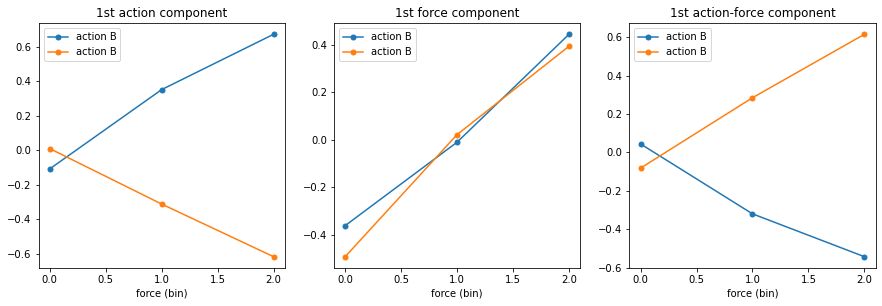

In [21]:

# figure(figsize=(16,7))
figure(figsize=(15,4.5))

i_comp = 0
subplot(131)

for a in range(num_actions):
    plot(force_array, Z['a'][i_comp,a], '.-', markersize=10, label='action '+action_list[i_a])
xlabel('force (bin)')
title('1st action component')
legend()
    
subplot(132)

for a in range(num_actions):
    plot(force_array,Z['f'][i_comp,a], '.-', markersize=10, label='action '+action_list[i_a])
xlabel('force (bin)')
title('1st force component')
legend()
    
subplot(133)

for a in range(num_actions):
    plot(force_array,Z['af'][i_comp,a], '.-', markersize=10, label='action '+action_list[i_a])
xlabel('force (bin)')
title('1st action-force component')
legend()
show()

The 1st mixing component looks merely like noise. But to be sure, we can run a significance analysis:

In [ ]:
significance_masks = dpca.significance_analysis(R,  trialR, n_shuffles=10, n_splits=10, n_consecutive)

We can highlight the significant parts of the demixed components with a black bar underneath. Note that there is no significant analysis time, since there are no classes to compute the significance over.

In [ ]:
time = arange(T)

figure(figsize=(16,7))
subplot(131)

for s in range(S):
    plot(time,Z['t'][0,s])

title('1st time component')
    
subplot(132)

for s in range(S):
    plot(time,Z['s'][0,s])

imshow(significance_masks['s'][0][None,:],extent=[0,250,amin(Z['s'])-1,amin(Z['s'])-0.5],aspect='auto',cmap='gray_r',vmin=0,vmax=1)
ylim([amin(Z['s'])-1,amax(Z['s'])+1])

title('1st stimulus component')
    
subplot(133)

for s in range(S):
    plot(time,Z['st'][0,s])

dZ = amax(Z['st'])-amin(Z['st'])
imshow(significance_masks['st'][0][None,:],extent=[0,250,amin(Z['st'])-dZ/10.,amin(Z['st'])-dZ/5.],aspect='auto',cmap='gray_r',vmin=0,vmax=1)
ylim([amin(Z['st'])-dZ/10.,amax(Z['st'])+dZ/10.])
    
title('1st mixing component')
show()